In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pickle

## loading activity dict

In [250]:
file = '../data/processed/transformers.pkl'
act = pickle.load(open(file, 'rb'))
len(act)

838

## making activity signal from dict

In [251]:
from social_phi import get_signal, get_event_signal

sig = get_signal(act, time_scale=24*3600, binarize=True)
sig.shape

(838, 949)

## temporal phi

In [266]:
import social_phi.phi
reload(social_phi.phi)

import social_phi
reload(social_phi)

from social_phi import phi_for_act_sig

phis, phis_orig, n_users = phi_for_act_sig(sig, window=50, hop=5, base=2)
len(phis)

/Users/soroushomranpour/Desktop/My Projects/Research/social consciousness/Social-Phi/social_phi/phi.py:13: RuntimeWarning: invalid value encountered in double_scalars
  prod = lambda x: x[0]*x[1]
/Users/soroushomranpour/Desktop/My Projects/Research/social consciousness/Social-Phi/social_phi/phi.py:23: RuntimeWarning: divide by zero encountered in log
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])
/Users/soroushomranpour/Desktop/My Projects/Research/social consciousness/Social-Phi/social_phi/phi.py:23: RuntimeWarning: invalid value encountered in double_scalars
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])


179

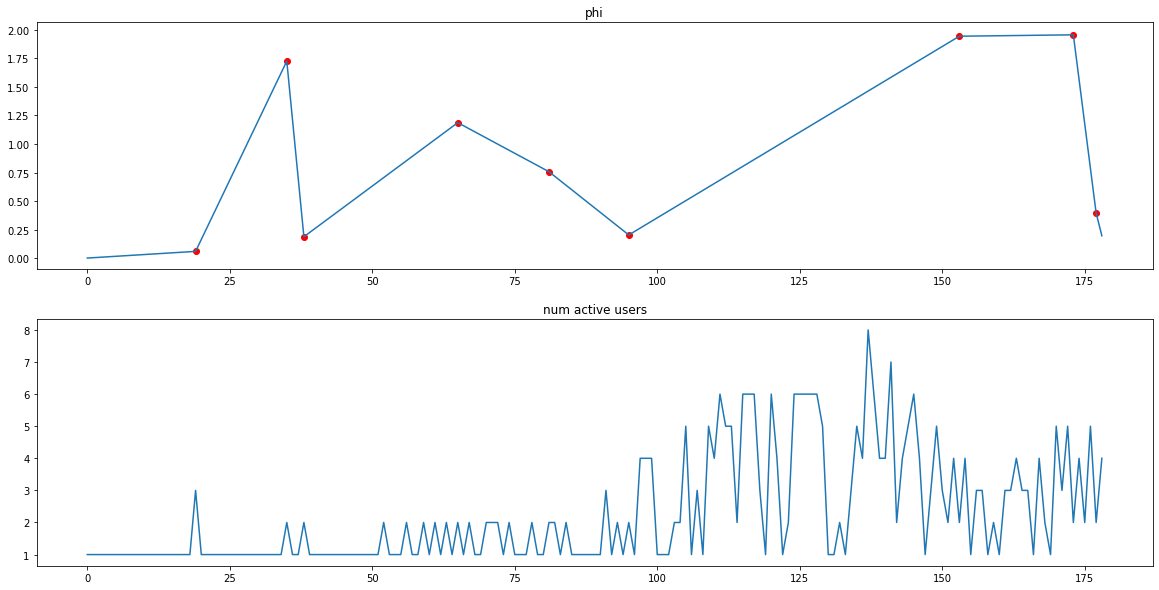

In [267]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('phi')
data = np.array(list(enumerate(phis_orig)))
plt.scatter(x=data[:,0], y=data[:,1], c='red')
plt.plot(phis)

plt.subplot(2,1,2)
plt.title('num active users')
plt.plot(n_users)


plt.show()

In [268]:
import datetime


timesteps = set()
for u in act:
    timesteps.update(act[u])
timesteps = sorted(list(timesteps))
m = int(timesteps[0] // (24*3600))*24*3600
M = int(timesteps[-1] // (24*3600))*24*3600
print(datetime.datetime.fromtimestamp(m), '=>', datetime.datetime.fromtimestamp(M))


hop = 5
window = 30
day = np.argmax(phis)*hop + window
offset = day*3600*24 + m
print(datetime.datetime.fromtimestamp(offset))

2018-10-29 03:30:00 => 2021-06-03 04:30:00
2021-04-11 04:30:00


In [269]:
print(
    'corr(phi, n_users) = {0:.4f}'.format(np.corrcoef(phis, n_users)[0,1])
)

corr(phi, n_users) = 0.3553


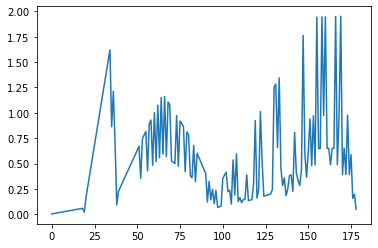

In [270]:
plt.plot(phis/n_users)
plt.show()

In [204]:
# avg_phi = []
# n_nans = []
# for h in range(1,30):
#     _, phis, _ = phi_for_act_sig(sig, window=30, hop=h, base=2)
#     avg_phi += [np.mean(phis[~np.isnan(phis)])]
#     n_nans += [np.isnan(phis).sum()/len(phis)]

# plt.plot(n_nans/lens)
# plt.plot(avg_phi)